# MKV-SDE with polynomial drift 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
from numpy import mean
from tabulate import tabulate
import mlflow
from itertools import product

In [ ]:
def monte_carlo(delta, T, N, M, X0):
    h = T / N
    X = X0 * np.ones(M)
    gamma1, gamma2 = np.zeros(N+1), np.zeros(N+1)
    gamma1[0], gamma2[0] = mean(X), mean(X**2)

    for i in range(N):
        W = np.random.normal(0, 1, M) 
        X = X + (delta * X + gamma1[i] - X * gamma2[i]) * h + X * math.sqrt(h) * W
        gamma1[i+1], gamma2[i+1] = mean(X), mean(X**2)
    
    return X, gamma1, gamma2 

def base(T, N, n, X0, tipo):

    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)

    if tipo == 'canonical':

        g = np.array([ cc ** i for i in range(n+1)])
        a1_0, a2_0 = np.sin(X0) * g[:,0], np.cos(X0) * g[:,0]

        return a1_0, a2_0, g

    elif tipo == 'lagrange':

        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        a1_0, a2_0 = np.sin(X0) * np.ones(n+1), np.cos(X0) * np.ones(n+1)

        return a1_0, a2_0, g

    else:
        return 'err'

def euler(a1, a2, delta, n, N, M, Z0, h, g):
    
    X, Z = Z0 * np.ones((N+1, M)), Z0 * np.ones((N+1, M))
    Y1, Y2 = np.zeros((N+1, n+1, M)), np.zeros((N+1, n+1, M))
    
    for i in range(N):
        c1 = np.dot(a1, g[:,i])
        c2 = np.dot(a2, g[:,i])
        
        W = np.random.normal(0, 1, (2, M)) 
    
        X[i+1] = X[i] + (delta * X[i] + c1 - X[i] * c2) * h + X[i] * math.sqrt(h) * W[0] 

        Y1[i+1] = Y1[i] + ( np.tile(g[:,i],(M, 1)).transpose() + delta * Y1[i] - Y1[i] * c2) * h + Y1[i] * math.sqrt(h) * W[1]
        Y2[i+1] = Y2[i] + ( - np.tile(g[:,i],(M, 1)).transpose() * Z[i] + delta * Y2[i] - Y2[i] * c2) * h + Y2[i] * math.sqrt(h) * W[1]

        Z[i+1] = Z[i] + (delta * Z[i] + c1 - Z[i] * c2) * h + Z[i] * math.sqrt(h) * W[1]
        
    return X, Z, Y1, Y2

def stochastic_gradient_descent(a1_0, a2_0, n, r0, rho, delta, N, M, X0, eps, h, g, gamma1, gamma2, K, tau):

    a1, a2 = a1_0, a2_0
    norm1, norm2 = LA.norm(gamma1), LA.norm(gamma2)
    deLa = np.tile(g.transpose()[:, :, np.newaxis], (1, 1, M))

    for m in range(5000):

        if ( ((LA.norm(np.dot(a1,g) - gamma1)/ norm1) < eps) and ((LA.norm(np.dot(a2,g) - gamma2)/ norm2) < eps) ):
                break

        # if (m % l == 0):
        #     if ( ((LA.norm(np.dot(a1,g) - gamma1)/ norm1) < eps) and ((LA.norm(np.dot(a2,g) - gamma2)/ norm2) < eps) ):
        #         break

        eta = r0 / ((m + 1) ** rho)

        Z, Ztilde, Y1tilde, Y2tilde = euler(a1, a2, delta, n, N, M, X0, h, g)

        v1, v2 = np.zeros(n+1), np.zeros(n+1)

        term1 = np.tile((Z - np.tile(np.dot(a1,g), (M,1)).transpose())[:, np.newaxis, :], (1, n+1, 1))
        term2 =  np.tile((Z ** 2 - np.tile(np.dot(a2,g), (M,1)).transpose())[:, np.newaxis, :], (1, n+1, 1))
        dephi2 = np.tile(2 * Ztilde[:, np.newaxis, :], (1, n+1, 1))

        v1 = mean(2 * h * np.sum( term1 * ( Y1tilde - deLa ) + term2 * dephi2 * Y1tilde, axis=0), axis=1)
        v2 = mean(2 * h * np.sum( term1 * Y2tilde + term2 * ( dephi2 * Y2tilde - deLa ), axis=0), axis=1)

        # norma = LA.norm(np.hstack((a1, a2)))
        # regterm = np.heaviside(norma - tau, 0) * 2 * K * (1 - tau/norma)

        a1 = a1 - eta * v1 # (v1 + regterm * a1)
        a2 = a2 - eta * v2 # (v2 + regterm * a2)

    return a1, a2, m

def set_experiment(experiment_name) -> str:
    # set experiment ID
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        experiment_id = experiment.experiment_id
    else:
        experiment_id = mlflow.create_experiment(experiment_name)
    
    return experiment_id

def run(run_name: str, experiment_name: str, params: dict) -> dict:

    print(f'starting run "{run_name}" ...')

    # set experiment ID
    experiment_id = set_experiment(experiment_name)
    
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True) as run:

        # log parameters and tags
        mlflow.log_params(params)

        start = time.process_time()   # the stopwatch starts
        X, gamma1, gamma2 = monte_carlo(params['delta'], params['T'], params['N1'], params['M1'], params['X0'])
        end = time.process_time()   # the stopwatch stops

        print("Euler - Monte Carlo execution time: ", end - start)
        print(" ")
        
        timeMC = end - start

        a1_0, a2_0, g = base(params['T'], params['N'], params['n'], params['X0'], params['tipo'])

        start = time.process_time()   # the stopwatch starts
        mm = [stochastic_gradient_descent(a1_0, a2_0, params['n'],params['r0'], params['rho'], params['delta'], params['N'], params['M'], 
                                            params['X0'], params['eps'], params['h'], 
                                            g, gamma1, gamma2, params['K'], params['tau']) for _ in range(params['repetition'])]
        end = time.process_time()   # the stopwatch stops

        timeSGD = (end - start)/params['repetition']
        
        results = {}
        results['min'] = min(mm)
        results['max'] = max(mm)
        results['average'] = mean(mm)
        results['timeSGD'] = timeSGD

        for result in results:
            mlflow.log_metric(result, results[result])
    
    print(f'... completed run "{run_name}"!')
    
    return results

## Plots

#### All Times

Euler - Monte Carlo execution time:  1.9899373249999712
 
SGD execution time:  0.026840956000000915
 
SGD steps:  27
 
Euler - Monte Carlo execution time:  9.811895885000013
 
SGD execution time:  0.3677545830000213
 
SGD steps:  79
 
Euler - Monte Carlo execution time:  19.572704439999995
 
SGD execution time:  7.3563880029999495
 
SGD steps:  756
 


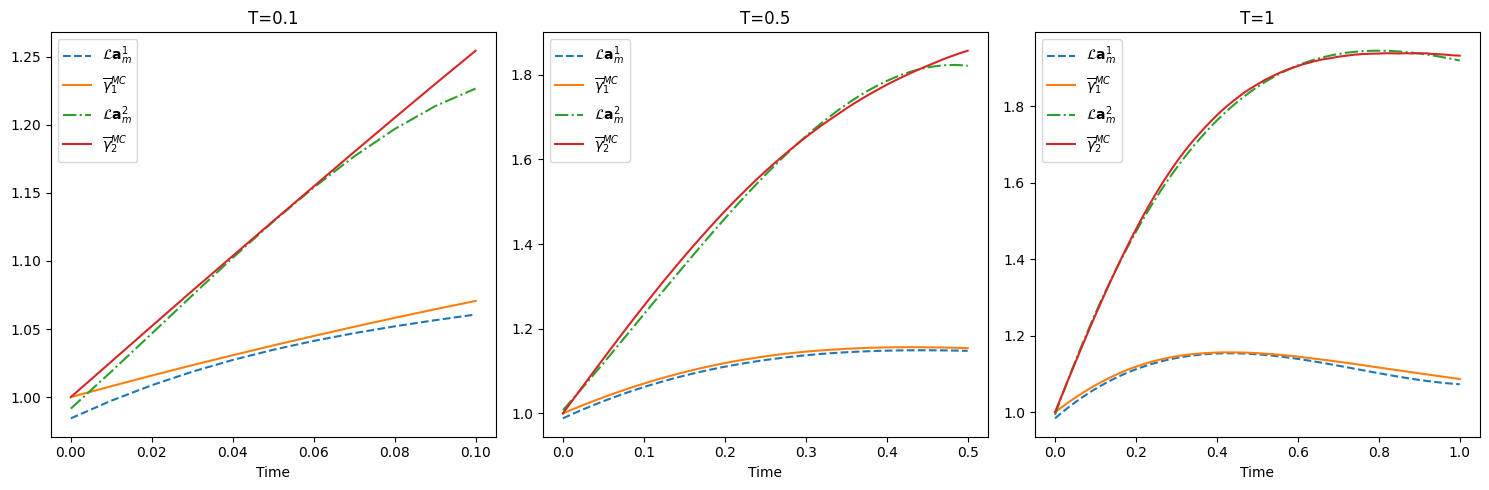

In [22]:
if __name__ == "__main__":

    delta = 0.8
    X0 = 1
    M1 = 10**7
    tipo = 'lagrange'
    eps = 0.01

    T = [0.1, 0.5, 1]
    N = [10, 50, 100]
    N1 = [10, 50, 100]
    h = 0.01

    n = 3 
    K = 0
    tau = 0.5
    M = 1000
    r0 = [10, 5, 1]
    rho = [0.6, 0.6, 0.6]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 rows, 2 columns
    axes = axes.flatten()  # Flatten to iterate easily

    for i in range(3):

        # Euler - Monte Carlo

        start = time.process_time()   # the stopwatch starts
        X, gamma1, gamma2 = monte_carlo(delta, T[i], N1[i], M1, X0)
        end = time.process_time()   # the stopwatch stops

        print("Euler - Monte Carlo execution time: ", end - start)
        print(" ")

        a1_0, a2_0, g = base(T[i], N[i], n, X0, tipo)

        start = time.process_time()   # the stopwatch starts
        a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n, r0[i], rho[i], delta, N[i], M, X0, eps, h, g, gamma1, gamma2, K, tau)
        end = time.process_time()   # the stopwatch stops

        print("SGD execution time: ", end - start)
        print(" ")
        print("SGD steps: ", m)
        print(" ")

        ax = axes[i]  # Select the subplot
        ax.set_xlabel("Time")
        ax.plot(np.linspace(0, T[i], N[i]+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
        ax.plot(np.linspace(0, T[i], N[i]+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
        ax.plot(np.linspace(0, T[i], N[i]+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
        ax.plot(np.linspace(0, T[i], N[i]+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
        ax.legend()
        ax.set_title(f"T={T[i]}")

    plt.tight_layout()
    plt.savefig("QUAD_all_T.pdf")
    plt.show()

#### $T=0.1$

Euler - Monte Carlo execution time:  1.988740120999978
 
SGD execution time:  0.02683331299999736
 
SGD steps:  26
 


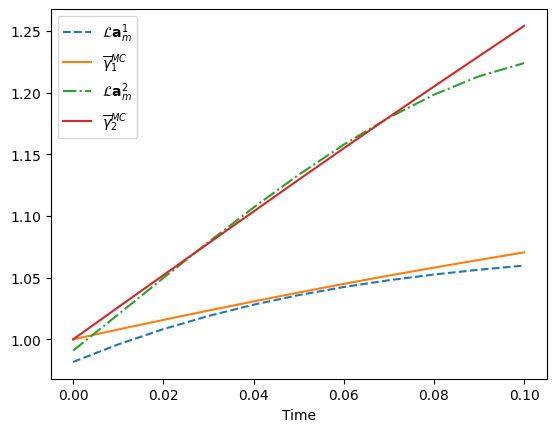

In [49]:
if __name__ == "__main__":

    delta = 0.8
    X0 = 1
    M1 = 10**7
    tipo = 'lagrange'
    eps = 0.01

    T = 0.1   # 0.5, 1, 2, 4
    N = 10
    N1 = 10
    h = T / N

    n = 3 
    K = 0
    tau = 0.5
    r0 = 10
    rho = 0.6
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(delta, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    a1_0, a2_0, g = base(T, N, n, X0, tipo)

    start = time.process_time()   # the stopwatch starts
    a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n,r0, rho, delta, N, M, X0, eps, h, g, gamma1, gamma2, K, tau)
    end = time.process_time()   # the stopwatch stops

    print("SGD execution time: ", end - start)
    print(" ")
    print("SGD steps: ", m)
    print(" ")

    fig = plt.figure()  
    plt.xlabel("Time") 
    plt.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
    plt.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
    plt.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
    plt.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
    plt.legend()
    plt.savefig("QUAD_T01.pdf")

#### $T=0.5$

Euler - Monte Carlo execution time:  9.816981455999999
 
SGD execution time:  0.43061460500000237
 
SGD steps:  92
 


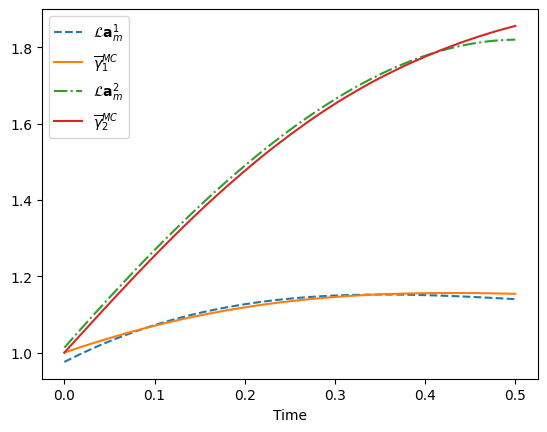

In [7]:
if __name__ == "__main__":

    delta = 0.8
    X0 = 1
    M1 = 10**7
    tipo = 'lagrange'
    eps = 0.01

    T = 0.5   # 0.5, 1, 2, 4
    N = 50
    N1 = 50
    h = T / N

    n = 3 
    K = 0
    tau = 0.5
    r0 = 5
    rho = 0.6
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(delta, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    a1_0, a2_0, g = base(T, N, n, X0, tipo)

    start = time.process_time()   # the stopwatch starts
    a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n,r0, rho, delta, N, M, X0, eps, h, g, gamma1, gamma2, K, tau)
    end = time.process_time()   # the stopwatch stops

    print("SGD execution time: ", end - start)
    print(" ")
    print("SGD steps: ", m)
    print(" ")

    fig = plt.figure()  
    plt.xlabel("Time") 
    plt.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
    plt.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
    plt.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
    plt.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
    plt.legend()
    plt.savefig("QUAD_T05.pdf")

#### $T=1$

Euler - Monte Carlo execution time:  19.58782320799999
 
SGD execution time:  10.21041839499999
 
SGD steps:  994
 


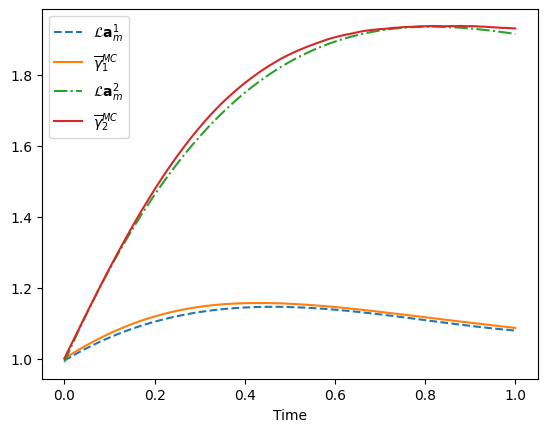

In [18]:
if __name__ == "__main__":

    delta = 0.8
    X0 = 1
    M1 = 10**7
    tipo = 'lagrange'
    eps = 0.01

    T = 1   # 0.5, 1, 2, 4
    N = 100
    N1 = 100
    h = T / N

    n = 3 
    K = 0
    tau = 0.5
    r0 = 1
    rho = 0.6
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(delta, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    a1_0, a2_0, g = base(T, N, n, X0, tipo)

    start = time.process_time()   # the stopwatch starts
    a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n,r0, rho, delta, N, M, X0, eps, h, g, gamma1, gamma2, K, tau)
    end = time.process_time()   # the stopwatch stops

    print("SGD execution time: ", end - start)
    print(" ")
    print("SGD steps: ", m)
    print(" ")

    fig = plt.figure()  
    plt.xlabel("Time") 
    plt.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
    plt.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
    plt.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
    plt.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
    plt.legend()
    plt.savefig("QUAD_T1.pdf")

## Tables

In [ ]:
# #### MAIN

# experiment_name = "Quadratic optimal table" 
# parent_run_name = "T=1"

# shared_params = {
#     'T': 1, 'n':3, 
#     # 'M':1000, 
#     'N':100, 'N1':100, 'delta':0.8, 'X0':1, 'M1':10**8, 'h':0.01, 
#     'K':0, #2, 
#     'tau':1, 
#     'r0':1, #'rho':0.6, 
#     'eps':0.01, 'repetition':10, 'tipo':'lagrange',
#     }

# explored_params = {
#     # 'n':[3,],
#     # 'tau':[1, 1.5],
#     # 'K':[0, 0.00003, 0.00007]
#     'rho': [0.6, 0.7],
#     'M': [1, 10, 100, 1000]
# }

# def main():

#     experiment_id = set_experiment(experiment_name)

#     args_list = [] 

#     for vals in product(*list(explored_params.values())):
#         params_subset = {key:val for key, val in zip(list(explored_params.keys()), vals)}
#         params_arg = {**shared_params, **params_subset}
#         run_name = '-'.join([f'{k}:{v}' for k, v in params_subset.items()])
#         args = [run_name, experiment_name, params_arg]
#         args_list.append(args)

#     with mlflow.start_run(experiment_id=experiment_id, run_name=parent_run_name): # parent run       

#         mlflow.log_params(shared_params)

#         results = []
#         for args in args_list:
#             # np.random.seed(19)
#             results.append(run(*args))

# if __name__ == "__main__":
#     main()

Euler - Monte Carlo execution time:  197.86743917
 
done n = 3
